<a href="https://colab.research.google.com/github/EkaterinaVoloshina/classification_of_dative_semantic_roles/blob/main/notebooks/semi_supervised_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Методы обучения с частичным привлечением учителя

Описание этого кода и интерпретация результата приведены в разделе 4.2 и 4.3 курсовой работы. 






Для дальнейшего кода нужна последняя версия библиотеки scikit-learn:

In [1]:
# ! pip install --upgrade scikit-learn

In [2]:
import random
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import xgboost as xgb

from torch import nn, optim
import torch
from torch.utils.data import DataLoader, TensorDataset

le = LabelEncoder()
one = OneHotEncoder()

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [ ]:
! git clone 'https://github.com/EkaterinaVoloshina/classification_of_dative_semantic_roles/'

### 1. Препроцессинг 

In [4]:
features = pd.read_csv('./classification_of_dative_semantic_roles/data/unannotated_data.csv')
features['prep'] = features['prep'].fillna(False).astype(int)
features['dobj'] = features['dobj'].fillna(False).astype(int)
features = features[features['d.lemma'].notna()]
features = features.drop(['d.lemma', 's.lemma', 'v.lemma'], axis=1)
features = features.drop(['Unnamed: 0', 'key'], axis=1)
features = features.fillna('none')
features = features.replace('no_subject', 'none')
features = features.apply(le.fit_transform)

In [5]:
data_w_answers = features[features['role'] != 0]
unlabeled = features[features['role'] == 0].drop('role', axis=1)
roles = le.fit_transform(data_w_answers['role'])

### 2. Метрики

In [6]:
def calculate_metrics(y_true, y_pred):
    """
    This function calculates different metrics
    """
    print(f'Accuracy is {accuracy_score(y_true, y_pred)}')
    print(f'Macro F1-score is {f1_score(y_test, y_pred, average="macro")}')
    print(f'Micro F1-score is {f1_score(y_test, y_pred, average="micro")}')
    print(f'Classification report: {classification_report(y_test, y_pred)}')
    df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred),
    index = [i for i in le.classes_], columns = [i for i in le.classes_])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data_w_answers.index, roles)

In [8]:
data = features.drop('role', axis=1).drop(X_test)
target = features['role'].drop(X_test)
target -= 1

In [9]:
one.fit(features.drop('role', axis=1))
one_data = one.transform(data)

### 3. Логистическая регрессия и Self-training модель, основанная на логистической регрессии

Accuracy is 0.615234375
Macro F1-score is 0.5235645984820316
Micro F1-score is 0.615234375
Classification report:               precision    recall  f1-score   support

           0       0.50      0.33      0.40        60
           1       0.64      0.55      0.59        77
           2       0.71      0.80      0.76        92
           3       0.27      0.10      0.15        29
           4       0.58      0.77      0.66       181
           5       0.72      0.49      0.59        73

    accuracy                           0.62       512
   macro avg       0.57      0.51      0.52       512
weighted avg       0.61      0.62      0.60       512



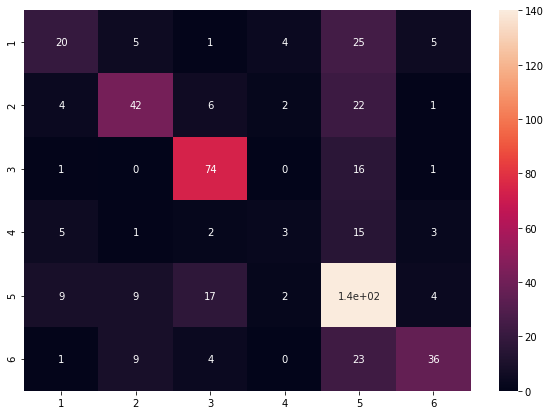

In [10]:
lg = LogisticRegression(solver='sag')
lg.fit(one.transform(features.iloc[X_train].drop('role', axis=1)), y_train)
y_pred = lg.predict(one.transform(features.iloc[X_test].drop('role', axis=1)))
calculate_metrics(y_test, y_pred)

Accuracy is 0.619140625
Macro F1-score is 0.5202686482904946
Micro F1-score is 0.619140625
Classification report:               precision    recall  f1-score   support

           0       0.49      0.37      0.42        60
           1       0.63      0.55      0.58        77
           2       0.70      0.80      0.75        92
           3       0.33      0.07      0.11        29
           4       0.59      0.78      0.67       181
           5       0.71      0.49      0.58        73

    accuracy                           0.62       512
   macro avg       0.58      0.51      0.52       512
weighted avg       0.61      0.62      0.60       512



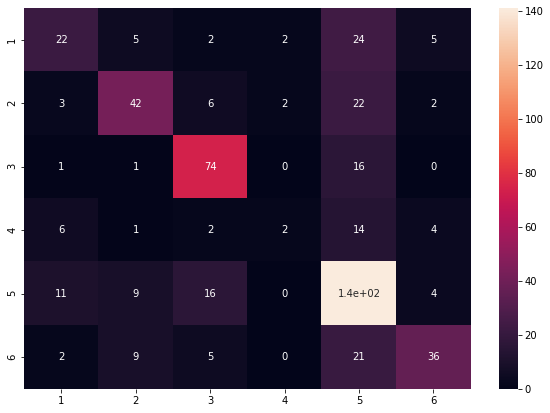

In [11]:
stc = SelfTrainingClassifier(LogisticRegression(solver='sag'), threshold=0.7, max_iter=15)
stc.fit(one_data, target)
y_pred = stc.predict(one.transform(features.iloc[X_test].drop('role', axis=1)))
calculate_metrics(y_test, y_pred)

### 4. Ансамбль решающих деревьев XGBoost и Self-training модель, основанная на XGBoost

Accuracy is 0.615234375
Macro F1-score is 0.5069799601377332
Micro F1-score is 0.615234375
Classification report:               precision    recall  f1-score   support

           0       0.59      0.32      0.41        60
           1       0.64      0.48      0.55        77
           2       0.73      0.79      0.76        92
           3       0.33      0.07      0.11        29
           4       0.57      0.84      0.68       181
           5       0.67      0.44      0.53        73

    accuracy                           0.62       512
   macro avg       0.59      0.49      0.51       512
weighted avg       0.61      0.62      0.59       512



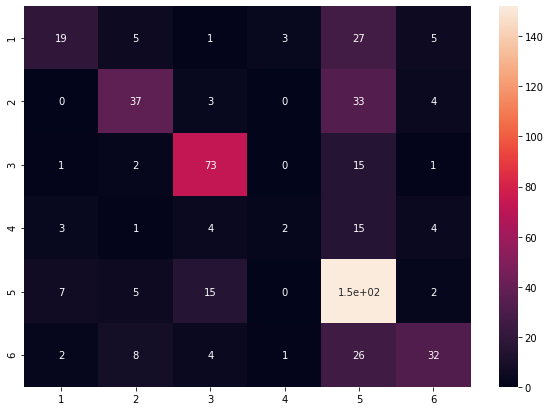

In [12]:
clf_r = xgb.XGBClassifier(n_estimators=1000, learning_rate=1e-2, max_depth=3, silent=True)
clf_r.fit(features.iloc[X_train].drop('role', axis=1), y_train)
y_pred = clf_r.predict(features.iloc[X_test].drop('role', axis=1))
calculate_metrics(y_test, y_pred)

Accuracy is 0.619140625
Macro F1-score is 0.5380477833224614
Micro F1-score is 0.619140625
Classification report:               precision    recall  f1-score   support

           0       0.62      0.30      0.40        60
           1       0.67      0.45      0.54        77
           2       0.69      0.79      0.74        92
           3       0.60      0.21      0.31        29
           4       0.57      0.83      0.67       181
           5       0.71      0.47      0.56        73

    accuracy                           0.62       512
   macro avg       0.64      0.51      0.54       512
weighted avg       0.63      0.62      0.60       512



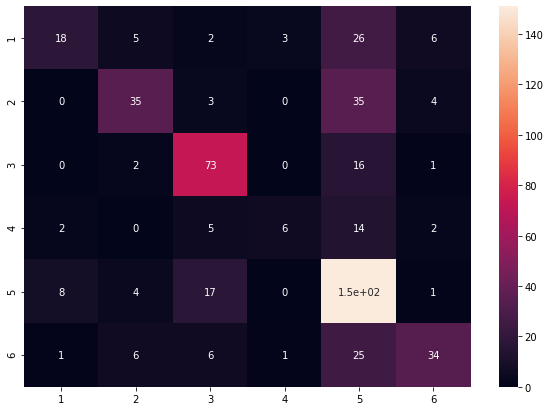

In [13]:
stc_boost = SelfTrainingClassifier(xgb.XGBClassifier(n_estimators=1000, learning_rate=1e-2, max_depth=3, silent=True), criterion='k_best', k_best=80, max_iter=30)
stc_boost.fit(data, target)
y_pred = stc_boost.predict(features.iloc[X_test].drop('role', axis=1).to_numpy())
calculate_metrics(y_test, y_pred)